# Sentiment Analysis On Amazon Customers Product Reviews

**Author:** Ruthy Yao
***

![Banner](./images/Banner.PNG)

## Overview

This project applied NLP models to convert review text into numerical representations and implemented machine learning models to predict sentiment. This will help in understanding customer feedback, identifying product strengths and weaknesses and improving the overall customer experience. 

## Business Problem

PawPure is an online store selling dog and cat food. Every day their customers leave thousands of reviews. These reviews are rich sources of customer feedback but are often unstructured, making manual analysis time-consuming and inefficient. The leadership team needs to quickly interpret the sentiments expressed in these reviews to understand how customers feel about their products, identify key pain points and adjust their business strategies accordingly. However, sorting through vast amounts of text data to understand customer sentiment (positive or negative) poses a significant challenge. 

The data analytics team was asked to automate the process of sentiment analysis using machine learning (ML) and natural language processing (NLP) techniques. By automating sentiment detection, the leadership team can gain real-time insights from reviews, leading to better decision-making, improved product offerings and enhanced customer satisfaction.

## Data Understanding

In [15]:
import sqlite3
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('ggplot')

In [16]:
# Loading the data
# To load the data, I will use the SQLITE dataset where I will fetch only the relevant data that I think will be useful for this analysis.
conn = sqlite3.connect('data/database.sqlite')

df = pd.read_sql_query("""
SELECT 
    Id, 
    ProductId,
    UserId,
    ProfileName,
    HelpfulnessNumerator,
    HelpfulnessDenominator,
    Score,
    Time,
    Summary,
    Text
FROM Reviews
""", conn)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [18]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [19]:
df['Score'].unique()

array([5, 1, 4, 2, 3], dtype=int64)

In [20]:
df['Time'].min()

939340800

The unix timestamp for 939340800 is 8/10/1999.

In [22]:
df['Time'].max()

1351209600

The unix timestamp for 1351209600 is 26/10/2012.

In [24]:
df['ProductId'].unique()

array(['B001E4KFG0', 'B00813GRG4', 'B000LQOCH0', ..., 'B003S1WTCU',
       'B004I613EE', 'B001LR2CU2'], dtype=object)

In [25]:
df['ProductId'].value_counts()

ProductId
B007JFMH8M    913
B0026RQTGE    632
B002QWHJOU    632
B002QWP89S    632
B002QWP8H0    632
             ... 
B004DSPTTM      1
B008C9QWU8      1
B007O5A6BM      1
B003Q4TZ08      1
B001LR2CU2      1
Name: count, Length: 74258, dtype: int64

* This dataset contains over 560,000 pieces of reviews dated from Oct 1999 to Oct 2012. 
* The review is scored from 1 to 5 with 5 being the most positive and 1 being the most negative.
* Each review has a summary and a body of the text.
* We can identify the Product ID, the user ID who wrote the reivew, the number of users who found the review helpful.

As we are only interested in the customer sentiment of the last 12 months. Hence I will subset the data with only the reviews posted from Nov 2011 and Oct 2022.

The timestamp of 01/11/2011 is 1320186491.

In [28]:
df = df[df['Time']>= 1320186491]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233325 entries, 1 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      233325 non-null  int64 
 1   ProductId               233325 non-null  object
 2   UserId                  233325 non-null  object
 3   ProfileName             233306 non-null  object
 4   HelpfulnessNumerator    233325 non-null  int64 
 5   HelpfulnessDenominator  233325 non-null  int64 
 6   Score                   233325 non-null  int64 
 7   Time                    233325 non-null  int64 
 8   Summary                 233323 non-null  object
 9   Text                    233325 non-null  object
dtypes: int64(5), object(5)
memory usage: 19.6+ MB


The extracted dataset contains 233,325 piece of customer reviews.

## Exploratory Data Analysis

In [32]:
# Let's first have a look of the overall rating score.
df['Score'].mean()

4.115872709739634

The average score is 4.12.

In [34]:
df['Score'].value_counts()

Score
5    143950
4     33809
1     24081
3     18299
2     13186
Name: count, dtype: int64

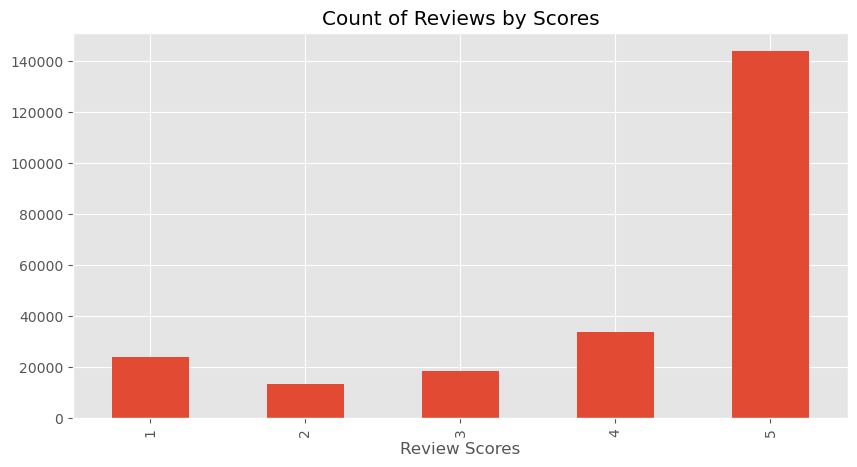

In [35]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind = 'bar',
          title = 'Count of Reviews by Scores',
          figsize =(10,5))
ax.set_xlabel('Review Scores')
plt.xticks(rotation=90)
plt.show()

Majority of the reviews are 5 stars rating.

In [37]:
# Let's have a look on some of the 5 scores.
df[df.Score == 5].head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...
17,18,B001GVISJM,AFKW14U97Z6QO,Becca,0,0,5,1345075200,Love it!,I am very satisfied with my Twizzler purchase....
18,19,B001GVISJM,A2A9X58G2GTBLP,Wolfee1,0,0,5,1324598400,GREAT SWEET CANDY!,"Twizzlers, Strawberry my childhood favorite ca..."
28,29,B00144C10S,A2F4LZVGFLD1OB,DaisyH,0,0,5,1338854400,YUMMY!,I got this for my Mum who is not diabetic but ...
55,56,B002GWHC0G,A2EFAW1P3DRXWO,TJ Fairfax,0,0,5,1349395200,Our guests love it!,We roast these in a large cast iron pan on the...
56,57,B004N5KULM,A202WR509428VF,amateur amazon shopper,2,2,5,1322438400,Awesome Deal!,Deal was awesome! Arrived before Halloween as...


In [38]:
# Let's have a look some 1 scores.
df[df.Score == 1].head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan..."
73,74,B0059WXJKM,A25VFHVGI4CFTP,Diana Robinson,0,1,1,1335744000,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...
99,100,B0019CW0HE,A2P6ACFZ8FTNVV,Melissa Benjamin,0,1,1,1331164800,Bad,I fed this to my Golden Retriever and he hated...
153,154,B002HQAXUW,A17ESTP5T7T1PH,Bumbeda1,1,1,1,1324944000,Rip off Price,These singles sell for $2.50 - $3.36 at the st...
167,168,B007B9J6G2,A34YK0ZTWOR858,NikkiBast,1,1,1,1345420800,Very Low quality,I don't know how long these sat on the back of...
168,169,B0064KO0BU,A34D61RQILOKIJ,TampaBayGal,1,1,1,1350086400,Not Banana Runts,"Besides being smaller than runts, they look th..."
229,230,B001L4ELRW,A1AK335P17JXL0,Victoria Brown,0,0,1,1345593600,Not Good,This candy is not as described. The middle is ...
233,234,B003ZFXJDW,A2KPPGFMPD20M6,Linda Albert,0,0,1,1343692800,Furniture Polish Taste,"Terrible! Artificial lemon taste, like Pledge ..."


In [39]:
# Let's have a look the products that are scored 5.
df.groupby(['ProductId'])['Score'].mean().sort_values(ascending = False).head(10)

ProductId
B002XTOHFU    5.0
B003LNNCLM    5.0
B003LN5Y7C    5.0
B003LN4BTE    5.0
B003LLV004    5.0
B003LKDVJI    5.0
B003LJZX86    5.0
B003LJZX18    5.0
B003LJZU2K    5.0
B003LJW6Q8    5.0
Name: Score, dtype: float64

In [40]:
# Let's have a look the products that are scored 1.
df.groupby(['ProductId'])['Score'].mean().sort_values(ascending = False).tail(10)

ProductId
B000B6J56I    1.0
B002XZNCFA    1.0
B0012BSK7Q    1.0
B002Y1LCNM    1.0
B0012BSB8O    1.0
B002Y2QSP8    1.0
B000B7R6QI    1.0
B002Y2SLQ2    1.0
B0060R8QLC    1.0
B001EO7KM2    1.0
Name: Score, dtype: float64

As this dataset doessn't have the product name and product category, this restrict us from extracting further insights on a graular level. However, we could clearly see which products are highly rated by customers and which are badly received by customers.

## Predicative Analysis

I'll train the ML algorithms to understand the product review dataset, extracting knowledege about whether a text indicates positive or negative sentiment. This training model will be deployed to assess customers' sentiment based their product reviews in the future.

I'll take the following steps:

1. Data preprocessing (tokenization, stemming, stop words removal etc.) to improve the data quality and reduce complexity.
2. Word embedding using TD-IDF technique to vectorize the text.
3. Load the processed dataset into ML models, evaluate models and choose the best one.

### Data Preprocessing

As we are only interested in whether the sentiment is `positive` or `negative`, I'll classify each review text into either "postive" or "negative" bucket. 
To achieve it, I will base on customer's rating `Score` for the classification. Specifically, Score above 3 will be classified as "positive" , otherwise the sentiment is "negative". 

In [46]:
df['Sentiment'] = df['Score'].apply(lambda x: 'positive' if x > 3 else 'negative')

I will only use the `Summary` field to predict the sentiment. Hence the `text` column will be excluded from the dataset.

Those columns such as the `product Id`, `User Id`, `time` and `Helpfullness` are irrelevant for this analysis, I'll exclude them from the dataset.

In [48]:
df = df[['Score','Summary','Sentiment']]

In [49]:
# check missing values.
df.isna().sum()

Score        0
Summary      2
Sentiment    0
dtype: int64

There are two missing values. Given that the dataset has over 233k pieces of data, I will remove the 2 with missing values.

In [51]:
df.dropna(inplace = True)

In [52]:
df['Sentiment'].value_counts(normalize = True)

Sentiment
positive    0.761858
negative    0.238142
Name: proportion, dtype: float64

3/4 of the reviews are positive, indicating the dataset is kind of inbalanced.

#### Text Preprocessing

I'll perform the following steps to preprocess the text in the `Summary` field in order to prepare the data for the Term-doc incidence matrix.

- Stop words removal
- Stemming
- Punctuations
- Lowering

##### Stopwords
* A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

![alt text](https://www.geeksforgeeks.org/wp-content/uploads/Stop-word-removal-using-NLTK.png)

In [57]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [58]:
'not' in stop

True

We'll not use stopwords removal as the review text have a lot of words like "not". Stopwords like 'not', "hadn't" for example, have strong negative signal. If we remove the stopwords, like"not", it will completely change the meaning of the reveiw. Hence I decide to keep the stop-words.

##### Stemming

Stemming will reduce the words to their root or base form. The goal of stemming is to simplify and standardize words, which helps improve the performance of information retrieval, text classification.

In [61]:
from nltk.stem import SnowballStemmer # Stemmers remove morphological affixes from words, leaving only the word stem.
snow = SnowballStemmer('english') 
print(snow.stem('tasty'))
print(snow.stem('joined'))
print(snow.stem('apples'))

tasti
join
appl


##### Punctuation Removal

In [63]:
import re
# cleaning punctuations from the sentence
sentence = "I'd like to have some coffee today!"
sentence = re.sub(r'[\'|"|#]', r'', sentence) # remove these punctuation
sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
sentence

'Id like to have some coffee today '

Let's combine all the text preprocessing steps.

In [65]:
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # lower case
    sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
    tokens = sentence.split()
    out = []
    for t in tokens:
        out.append(snow.stem(t))
    out = " ".join(out)
    out = re.sub(r'[\'|"|#]', r'', out) # remove these punctuation
    return out    

In [66]:
df["Summary_Clean"] = df["Summary"].apply(cleanup)

In [67]:
df.head()

,Score,Summary,Sentiment,Summary_Clean
1,1,Not as Advertised,negative,not as advertis
4,5,Great taffy,positive,great taffi
5,4,Nice Taffy,positive,nice taffi
6,5,Great! Just as good as the expensive brands!,positive,great just as good as the expens brand
7,5,"Wonderful, tasty taffy",positive,wonder tasti taffi


### Word Cloud

In [69]:
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS

In [70]:
mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=None,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

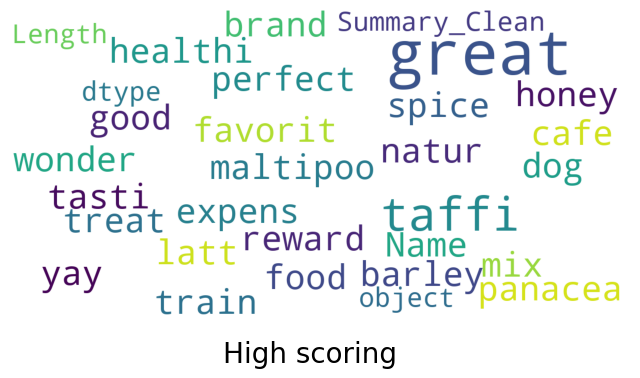

In [71]:
show_wordcloud(df.Summary_Clean.loc[df.Score == 5], title = "High scoring")

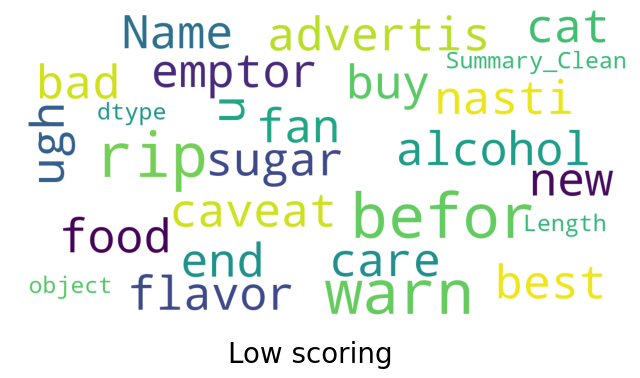

In [72]:
show_wordcloud(df.Summary_Clean.loc[df.Score == 1], title = "Low scoring")

According to the word cloud, the high-scored review mentioned "tasty", "heatlhy", "brand", "barley" repeatedly, whereas low-scored review called out "sugar", "alcohol","flavor", "bad", "Nasty" quite often.

### Model Development

#### train test split

In [76]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state = 1)
print("%d items in training data, %d in test data" % (len(train), len(test)))

186658 items in training data, 46665 in test data


In [77]:
train = train.reset_index(drop=True)
train.head()

,Score,Summary,Sentiment,Summary_Clean
0,5,Worked for Me,positive,work for me
1,5,Great Value,positive,great valu
2,5,Best Mint Tea by my ruler.,positive,best mint tea by my ruler
3,1,Not good that I expect,negative,not good that i expect
4,1,Stale and Poorly packaged,negative,stale and poor packag


In [78]:
test = test.reset_index(drop=True)
test.head()

,Score,Summary,Sentiment,Summary_Clean
0,5,OH SO GOOD!!,positive,oh so good
1,5,yum yum,positive,yum yum
2,5,Good for your health,positive,good for your health
3,5,"great tasting soup, gluten free",positive,great tast soup gluten free
4,5,great product,positive,great product


#### Feature Engineering

I'll use the following three NLP models to convert the text to vectors.

1) Uni-gram BOW
2) Bi-gram BOW
3) TF-IDF

#### *1) Uni-gram BoW*

Uni-gram convert every word to a feature. 

In [82]:
from sklearn.feature_extraction.text import CountVectorizer

In [83]:
train['Summary_Clean'].values

array(['work for me', 'great valu', 'best mint tea by my ruler', ...,
       'do not buy - made in china', 'dog said 5 star i say 4',
       'love it love it'], dtype=object)

In [84]:
# words the occur less than 5 times will be ignored to avoid overfitting.
uni_gram = CountVectorizer(min_df = 5, binary = True) # only use keyword which shows up more than 5 times. 
uni_gram_vectors_train = uni_gram.fit_transform(train['Summary_Clean'].values)
uni_gram_vectors_test = uni_gram.transform(test['Summary_Clean'].values)

In [85]:
uni_gram_vectors_train.shape

(186658, 5246)

Uni-gram method identified 5246 unique words, each refresent a feature.

In [87]:
features = uni_gram.get_feature_names_out()
features[-20:]

array(['yumo', 'yumyum', 'yunnan', 'yup', 'yuuuuummmmmmyyyyi', 'zealand',
       'zen', 'zero', 'zesti', 'zeus', 'zevia', 'zico', 'zing', 'zingi',
       'zip', 'ziwipeak', 'zoe', 'zone', 'zotz', 'zuke'], dtype=object)

#### *2) Bi-gram BoW*

Bi-gram is predicts the probability of a word in a sequence based on the previous word. It considers pairs of consecutive words (bigrams) and estimates the likelihood of encountering a specific word given the preceding word in a text or sentence.

In [89]:
bi_gram = CountVectorizer(ngram_range=(1,2), min_df = 5, binary = True) # 1 means the minimum is unigram, 2 means max is bigrams, 
bi_gram_vectors_train = bi_gram.fit_transform(train['Summary_Clean'].values)
bi_gram_vectors_test = bi_gram.transform(test['Summary_Clean'].values)

In [90]:
bi_gram_vectors_train.shape

(186658, 23392)

Bi-gram model identified 23392 unique pair of words, each refresent a feature.

In [92]:
features = bi_gram.get_feature_names_out()
features[-20:]

array(['zing', 'zing of', 'zingi', 'zip', 'ziwipeak', 'ziwipeak real',
       'zoe', 'zoe favorit', 'zoe oliv', 'zone', 'zotz', 'zuke',
       'zuke chicken', 'zuke dog', 'zuke hip', 'zuke is', 'zuke mini',
       'zuke peanut', 'zuke product', 'zuke treat'], dtype=object)

#### *3) TF-IDF*

* TF*IDF is an information retrieval technique that weighs a term's frequency (TF) and its inverse document frequency (IDF). Each word or term has its respective TF and IDF score. The product of the TF and IDF scores of a term is called the TF*IDF weight of that term

![alt text](https://1.bp.blogspot.com/-tnzPA6dDtTU/Vw6EWm_PjCI/AAAAAAABDwI/JatHtUJb4fsce9E-Ns5t02_nakFtGrsugCLcB/s1600/%25E8%259E%25A2%25E5%25B9%2595%25E5%25BF%25AB%25E7%2585%25A7%2B2016-04-14%2B%25E4%25B8%258A%25E5%258D%25881.39.07.png)

TF = (Number of times term t appears in a document)/(Number of terms in the document)

IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 5)
tfidf_vectors_train = tfidf.fit_transform(train['Summary_Clean'].values)
tfidf_vectors_test = tfidf.transform(test['Summary_Clean'].values)

In [96]:
tfidf_vectors_train.shape

(186658, 23392)

In [97]:
features = tfidf.get_feature_names_out()
features[0:20]

array(['00', '000', '000 tea', '02', '02 12', '09', '09 02', '0z',
       '0z can', '10', '10 10', '10 12', '10 calori', '10 minut',
       '10 ounc', '10 oz', '10 pack', '10 star', '10 year', '100'],
      dtype=object)

##### Comparison of BoW and TF-IDF

In Bag-of-Words (BoW), text is represented by treating each word as a feature in a vector. The model completely ignores word order, syntax, and semantics. Each word in the corpus corresponds to a dimension in the vector, and the value represents how many times the word appears in the document.

TF-IDF, on the other hand, enhances the BoW model by adding layer of consideration: the rarity of the word across the entire dataset. In addition to  considering the word frequency (TF), it also introduces the inverse document frequency (IDF) to adjust the weight of each word. Words that appear frequently in a document but are rare across the entire corpus are given more importance.

As TF-IDF adjusts word importance by considering both the frequency of a term within a document and its rarity across the corpus. This helps capture the significance of words in the context of the entire dataset. In my opinion, TF-IDF is a better NLP model. Hence I will load the TF-IDF vectorized data to the machine learning model. 

In [99]:
prediction = dict() # create a disctionary to store the prediction output.
prob = dict()  # create a dictionary to store the probability value of the predicted output.

#### Model Training

I'll train two models:

1) Logistic Regression Model.
2) Random Forest Model.

##### *1) Logistic Regression Model*

In [103]:
from sklearn.linear_model import LogisticRegression

In [104]:
# The first time initiate the model, need to run the below two lines of codes. 
# Once the model is saved in a pickle file, we just need to run the pickle.load(open) code.

# logreg_tfidf = LogisticRegression(C = 1e5, class_weight = 'balanced')
# logreg_tfidf_result = logreg_tfidf.fit(tfidf_vectors_train, train['Sentiment'])
logreg_tfidf = pickle.load(open('amazon.lr.pickle', 'rb'))

In [105]:
prediction['logistic_tfidf'] = logreg_tfidf.predict(tfidf_vectors_test)

In [106]:
prediction['logistic_tfidf']

array(['positive', 'positive', 'positive', ..., 'positive', 'positive',
       'positive'], dtype=object)

In [107]:
# Let's have a look of the predicted value vs the actual values.

import collections
print('test data')
print(test['Sentiment'].value_counts())
print('--------------')
print('predicted data')
print(collections.Counter(prediction['logistic_tfidf']))

test data
Sentiment
positive    35613
negative    11052
Name: count, dtype: int64
--------------
predicted data
Counter({'positive': 37263, 'negative': 9402})


There are 37,263 reviews are predicted to be positive vs actual positive sentiment of 35,613. 9,402 reviews are predicted to be negative sentiment vs actual 11,052 negative reviews. which is not too bad.

In [109]:
prob['logistic_tfidf'] = logreg_tfidf.predict_proba(tfidf_vectors_test)

In [110]:
prob['logistic_tfidf']

array([[0.02076739, 0.97923261],
       [0.00551057, 0.99448943],
       [0.07765659, 0.92234341],
       ...,
       [0.40373367, 0.59626633],
       [0.02790772, 0.97209228],
       [0.14212246, 0.85787754]])

In [111]:
prob['logistic_tfidf'][:,1]

array([0.97923261, 0.99448943, 0.92234341, ..., 0.59626633, 0.97209228,
       0.85787754])

### Model Evaluation

Let's build the ROC curve to evaluate and compare the models. The curve with the highest AUC value will be our "best" algorithm.

In [113]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

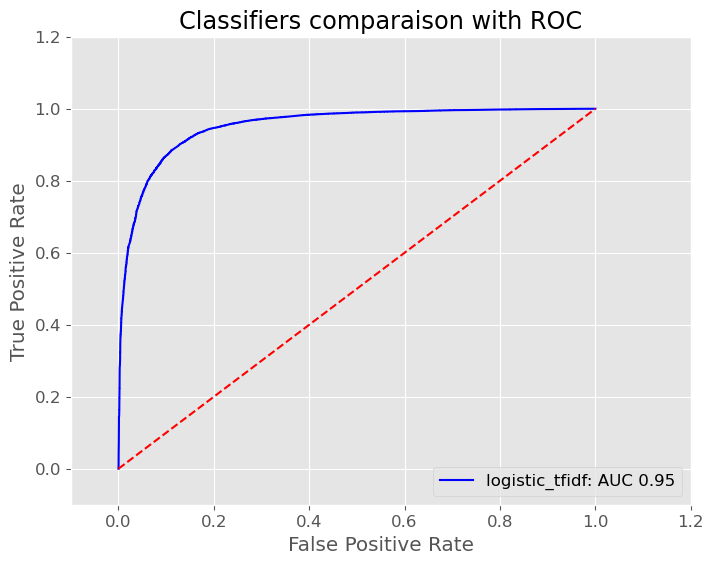

In [114]:
cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = \
            roc_curve(test['Sentiment'].values, prob['logistic_tfidf'][:,1], pos_label = 'positive')
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [115]:
print(metrics.classification_report(test['Sentiment'].values, 
                                    prediction['logistic_tfidf'], 
                                    target_names = ["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.87      0.74      0.80     11052
    positive       0.92      0.96      0.94     35613

    accuracy                           0.91     46665
   macro avg       0.89      0.85      0.87     46665
weighted avg       0.91      0.91      0.91     46665



Let's refresh on what Precision and Recall are (more here https://en.wikipedia.org/wiki/Precision_and_recall)

![Precision_Recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)

In our case, the recall and precision are low for the negative class. More improvement can be made.

#### Identify the most important words that determine the sentiment.

We will use the co-effients as the indicator of the importance of the words. i.e. the higher the positive co-efficent, the more important for a postive class. Likewise, the higher the negative co-efficent, the more important of the word for a negative sentiment.

In [120]:
feature = tfidf.get_feature_names_out()
feature_coefs = pd.DataFrame(
    data = list(zip(feature, logreg_tfidf.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')

,feature,coef
14058,not,-10.624847
22915,worst,-8.854885
10135,horribl,-7.487259
19643,terribl,-7.301940
5772,disappoint,-7.123186
...,...,...
12287,love,7.577937
6710,excel,8.762426
14075,not bad,9.550776
9029,great,10.728529


The words "worst", "horrible", "terrible", "disappointing" are highly correlated with a negative sentiment; On the other hand, words such as "best","great", "not bad", "excel" and "love" are the strong indication of a positive sentiments. This is quite alligned with our common sense. 

##### *2) Random Forest Model*

In [123]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
# rf_tfidf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced')
# rf_tfidf_result = rf_tfidf.fit(tfidf_vectors_train, train['Sentiment'])

rf_tfidf = pickle.load(open('amazon.rf.pickle', 'rb'))

In [125]:
prediction['rf_tfidf'] = rf_tfidf.predict(tfidf_vectors_test)

In [126]:
print('test data')
print(test['Sentiment'].value_counts())
print('--------------')
print('predicted data')
print(collections.Counter(prediction['rf_tfidf']))

test data
Sentiment
positive    35613
negative    11052
Name: count, dtype: int64
--------------
predicted data
Counter({'positive': 36017, 'negative': 10648})


In [127]:
prob['rf_tfidf'] = rf_tfidf.predict_proba(tfidf_vectors_test)
prob['rf_tfidf'][0:10,1]

array([1.        , 1.        , 1.        , 0.99      , 1.        ,
       0.98180995, 1.        , 0.        , 0.1228982 , 0.35      ])

In [128]:
test['Sentiment'][0:10]

0    positive
1    positive
2    positive
3    positive
4    positive
5    positive
6    positive
7    negative
8    negative
9    negative
Name: Sentiment, dtype: object

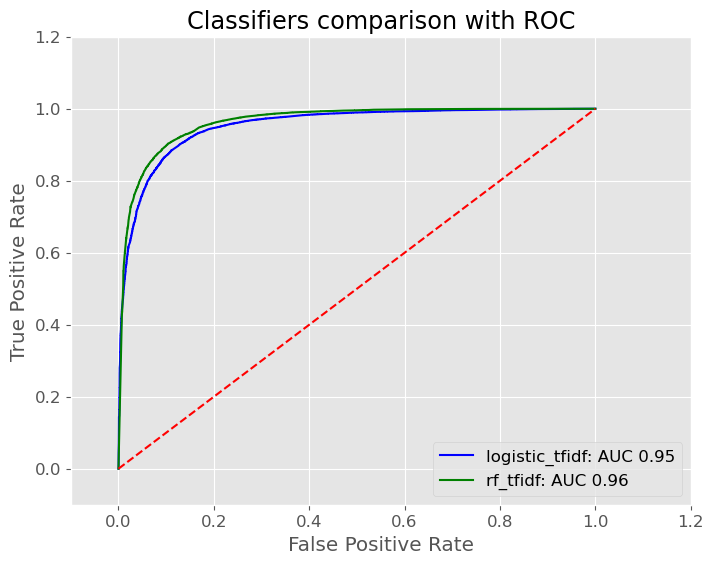

<Figure size 800x600 with 0 Axes>

In [222]:
cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = \
            roc_curve(test['Sentiment'].values, prob[model][:,1], pos_label = 'positive')
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The ROC curve shows that Random Forecast Model is slightly better than the logistic model.

In [131]:
print(metrics.classification_report(test['Sentiment'].values, 
                                    prediction['logistic_tfidf'], 
                                    target_names = ["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.87      0.74      0.80     11052
    positive       0.92      0.96      0.94     35613

    accuracy                           0.91     46665
   macro avg       0.89      0.85      0.87     46665
weighted avg       0.91      0.91      0.91     46665



In [132]:
print(metrics.classification_report(test['Sentiment'].values, 
                                    prediction['rf_tfidf'], 
                                    target_names = ["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.85      0.82      0.83     11052
    positive       0.94      0.95      0.95     35613

    accuracy                           0.92     46665
   macro avg       0.90      0.89      0.89     46665
weighted avg       0.92      0.92      0.92     46665



* Precision tells us of all the customer reviews that were predicted as positive (or negative), how many were actually positive (or negative). 
* Recall (Sensitivity) tells us of all the positive (or negative) reviews, how many did we correctly predict as positive (or negative) sentiment. 
* In this particular business scenario, I believe the most critical part is to be able to correctly identify the negative sentiment.
* If the customer posted a negative review, we want the model to be able to detect it, rather than misclassify it as positive review, i.e. we want to have a higher **Recall** for the negative class.
* We also want to minimize the cases where the model misclassifies a negative review (The model predicts a customer's review as a positive, but it is actually a negative review), i.e. we want a higher **Precision** for the positive class.

With that in mind, the Random Forecast Model is superior over Logistical Regression.
* Recall for negative class: 0.82 vs 0.74
* Precision for positive class: 0.94 vs 0.92

### Feature Importance 

Let's use the feature importance technique to identify the most important words in a sentiment class. 

In [135]:
feature = bi_gram.get_feature_names_out()
rf_feature_importance = pd.DataFrame(data = list(zip(feature, rf_tfidf.feature_importances_)),
    columns = ['feature', 'importance'])
rf_feature_importance.sort_values(by='importance', ascending=False).head(50)

,feature,importance
14058,not,0.038320
9029,great,0.031131
5456,delici,0.016289
2219,best,0.015837
12287,love,0.015058
5772,disappoint,0.011922
8646,good,0.011597
3163,but,0.010529
6710,excel,0.009782
23285,yummi,0.009351


Words such as "great", "delicious", "best", "love", "disappoint", "bad", "terrible" are the most important words that determine the sentiment class. 

Those words such as "delicious", "tasty", "yummy", "nasty", "disgust", "yuck", "stale" appearing on top of the list indicates that taste, freshness are the area that accounts major part of the customer satisfaction and customer sentiment.

In [137]:
# Save the two models into pickle file. Next time if we want to use the model, we just open it through pickle.

pickle.dump(logreg_tfidf, open('amazon.lr.pickle', 'wb'))
pickle.dump(rf_tfidf, open('amazon.rf.pickle', 'wb'))    

# The first time we create the model we will run the below "load and open" code to create the pickle file. 
# Once the pickle file created, moving forward, we will just open it through pickle.
# logreg_tfidf = pickle.load(open('amazon.lr.pickle', 'rb'))
# rf_tfidf = pickle.load(open('amazon.rf.pickle', 'rb'))

## Model Summary & Application

The goal for the project was to build a model that would accurately predict the customers' sentiment. This would allow us to appropriately assess customer's reception of our products so it will inform us on customer satisfaction, product improvement and marketing strategy. A secondary goal was to understand what the drivers are for the sentiment, be it taste, healthiness or packaging, etc. so we can identify our products strengths and weakness, targeting on areas for improvement.

Based upon these, the chosen the model is the Random Forest as it gave us higher AUC. It particularly works better for discerning the negative sentiment. Besides, the feature importance does a better job in identifying the key drivers behind the negative sentiment. 

The sentiment classification can direct us to action on the following: 

* **Product Improvement**: Since most of the negative sentiment is around the "taste" and "freshness", it would be worth focusing on improving the taste of our products and how to better preserve the food to maintain the freshness.
* **Customer Satisfaction**: Track sentiment trends over time to see if new product launches are being well received.
* **Marketing Strategy**: Highlight positive reviews to promote top-performing products.

### Growth & Next Steps

* Try using Logistic regression + L1 regularization
* Try other machine learning methods.
* Classify the sentiment into multi-class(postive, neutral, negative) and run a multiclass classification model.